In [1]:
import torch
import matplotlib.pyplot as plt
from einops import reduce, repeat, rearrange
import math
from time import perf_counter, time
import seaborn as sns


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def physical_tournaments(fitnesses, tournament_size, num_genomes):
  *_, P = fitnesses.size()
  num_competitors = num_genomes * tournament_size

  indices = torch.multinomial(torch.ones_like(fitnesses, dtype=torch.double), num_competitors, replacement=True)
  fit = fitnesses[indices]
  # Reshape into tournaments
  fit = rearrange(fit, '... (n s) -> ... n s', n=num_genomes, s=tournament_size)

  winners, winner_indices = fit.max(dim=-1)
  return winners


def probabilities(fitnesses, tournament_size, num_genomes):
  indices = torch.argsort(fitnesses, dim=-1).double()
  subtraction = rearrange(torch.arange(tournament_size - 1), 'k -> 1 k')

  products = indices.unsqueeze(-1) - subtraction.to(fitnesses.device, torch.double)
  products[products < 0] = 0

  log_probs = products.log().sum(dim=-1) # values probably explode if you compute directly
  probs = torch.exp(log_probs - math.log(fitnesses.size(-1)) * (tournament_size - 2)) # scale in logspace before exponentiating

  indices = torch.multinomial(probs, num_genomes, replacement=True)
  return fitnesses[indices]

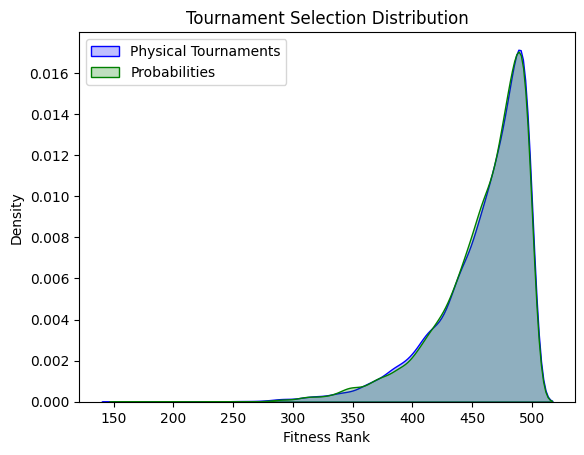

In [4]:
tournament_size = 11
num_genomes = 10000

fitnesses = torch.arange(0, 500, 1, dtype=torch.float, device=device)

tournaments = physical_tournaments(fitnesses, tournament_size, num_genomes)
probs = probabilities(fitnesses, tournament_size, num_genomes)


sns.kdeplot(tournaments.detach().cpu().numpy(), fill=True, color="blue", label="Physical Tournaments")
sns.kdeplot(probs.detach().cpu().numpy(), fill=True, color="green", label="Probabilities")

plt.title("Tournament Selection Distribution")
plt.xlabel("Fitness Rank")
plt.ylabel("Density")
plt.legend(loc="upper left")

plt.show()

In [5]:
def _sample(population: torch.Tensor, fitnesses: torch.Tensor, probs: torch.Tensor, num_genomes: int, replacement: bool=True) -> torch.Tensor:
  selection_indices = torch.multinomial(probs, num_samples=num_genomes, replacement=replacement)
  return _extract_genomes(population, fitnesses, selection_indices)

def _extract_genomes(population: torch.Tensor, fitnesses: torch.Tensor, selection_indices: torch.Tensor) -> torch.Tensor:
  *_, P, G = population.size()
  selected = population.gather(dim=-2, index=repeat(selection_indices, '... N -> ... N G', G=G))
  return selected, fitnesses.gather(dim=-1, index=selection_indices)


class TournamentSelection():
  def __init__(self, tournament_size: int):
    self.tournament_size = tournament_size

  def __call__(self, population: torch.Tensor, fitnesses: torch.Tensor, num_genomes: int) -> torch.Tensor:
    *_, P, G = population.size()
    num_competitors = num_genomes * self.tournament_size

    # Oversample the population to get enough competitors for given tournament size
    pop, fit = _sample(population, fitnesses, torch.ones_like(fitnesses, dtype=torch.double), num_competitors, replacement=True)

    # Reshape into tournaments
    fit = rearrange(fit, '... (n s) -> ... n s', n=num_genomes, s=self.tournament_size)
    pop = rearrange(pop, '... (n s) G -> ... n s G', n=num_genomes, s=self.tournament_size)

    winners, winner_indices = fit.max(dim=-1)
    selected = pop.gather(dim=1, index=repeat(winner_indices, '... n -> ... n 1 G', G=G)).squeeze(-2)
    return selected, winners



class TournamentSelectionProbs():
  def __init__(self, tournament_size: int, replacement=True):
    self.subtraction = rearrange(torch.arange(tournament_size - 1), 'k -> 1 k')
    self.k_minus_2 = tournament_size - 2
    self.replacement = replacement

  def __call__(self, population: torch.Tensor, fitnesses: torch.Tensor, num_genomes: int) -> torch.Tensor:
    indices = torch.argsort(fitnesses, dim=-1).double()

    products = indices.unsqueeze(-1) - self.subtraction.to(population.device, torch.double)
    products[products < 0] = 0

    log_probs = products.log().sum(dim=-1) # values probably explode if you compute directly
    probs = torch.exp(log_probs - math.log(fitnesses.size(-1)) * self.k_minus_2) # scale in logspace before exponentiating

    return _sample(population, fitnesses, probs, num_genomes, replacement=self.replacement)



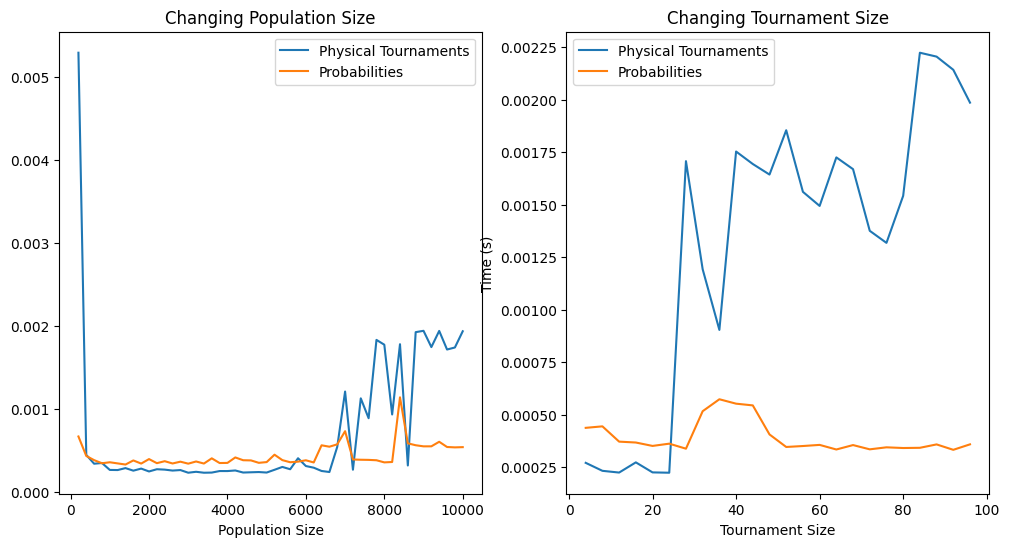

In [7]:
G = 1000

ts_times = []
ts_times_ts = []
tsp_times = []
tsp_times_ts = []

tournament_size=11
ts = TournamentSelection(tournament_size)
tsp = TournamentSelectionProbs(tournament_size)

pop_sizes = range(200, 10100, 200)
for p in pop_sizes:
  pop = torch.rand(p, G, dtype=torch.float, device=device)
  fitnesses = torch.rand(p, dtype=torch.float, device=device)
  torch.cuda.empty_cache()
  torch.cuda.synchronize()

  start = perf_counter()
  ts(pop, fitnesses, p)
  ts_times.append(perf_counter() - start)


for p in pop_sizes:
  pop = torch.rand(p, G, dtype=torch.float, device=device)
  fitnesses = torch.rand(p, dtype=torch.float, device=device)
  torch.cuda.empty_cache()
  torch.cuda.synchronize()

  start = perf_counter()
  tsp(pop, fitnesses, p)
  tsp_times.append(perf_counter() - start)



p = 3000
pop = torch.rand(p, G, dtype=torch.float, device=device)
fitnesses = torch.rand(p, dtype=torch.float, device=device)

tournament_sizes = range(4, 100, 4)
for s in tournament_sizes:
  ts = TournamentSelection(s)
  torch.cuda.empty_cache()
  torch.cuda.synchronize()

  start = perf_counter()
  ts(pop, fitnesses, p)
  ts_times_ts.append(perf_counter() - start)


for s in tournament_sizes:
  tsp = TournamentSelectionProbs(s)
  torch.cuda.empty_cache()
  torch.cuda.synchronize()

  start = perf_counter()
  tsp(pop, fitnesses, p)
  tsp_times_ts.append(perf_counter() - start)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first set on the first subplot
ax1.plot(pop_sizes, ts_times, label='Physical Tournaments')
ax1.plot(pop_sizes, tsp_times, label='Probabilities')
ax1.legend()

# Plot the second set on the second subplot
ax2.plot(tournament_sizes, ts_times_ts, label='Physical Tournaments')
ax2.plot(tournament_sizes, tsp_times_ts, label='Probabilities')
ax2.legend()

plt.ylabel('Time (s)')
ax1.set_xlabel('Population Size')
ax2.set_xlabel('Tournament Size')
ax1.set_title('Changing Population Size')
ax2.set_title('Changing Tournament Size')

# Display the plots
plt.show()